# Resume Job Category Prediction

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load Dataset and Basic Info

In [2]:
# Load Dataset
df = pd.read_csv("/kaggle/input/resume/Dataset.csv")

# Dataset shape and info
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
df.info()


Dataset contains 13389 rows and 2 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13389 entries, 0 to 13388
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  13389 non-null  object
 1   Text      13389 non-null  object
dtypes: object(2)
memory usage: 209.3+ KB


# Data Cleaning and Preprocessing

In [3]:
# Define text cleaning function for resumes
def clean_text(text):
    text = text.replace('\r\n', '\n').replace('\r', '\n')  # Normalize line endings
    text = re.sub(r'\n+', ' ', text)  # Replace multiple newlines with space
    
    text = re.sub('http\S+\s', ' ', text)       # Remove URLs
    text = re.sub('RT|cc', ' ', text)            # Remove RT and cc
    text = re.sub('#\S+\s', ' ', text)           # Remove hashtags
    text = re.sub('@\S+', ' ', text)             # Remove mentions
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7f]', ' ', text)   # Remove non-ASCII characters
    text = re.sub('\s+', ' ', text)              # Remove extra whitespace
    
    return text.lower().strip()

# Apply cleaning
df['Text'] = df['Text'].apply(clean_text)

# Add text length column for filtering

In [4]:
df['Text_Length'] = df['Text'].apply(len)

# Remove duplicates and filter too short/long resumes

In [5]:
df = df.drop_duplicates()
df = df[(df['Text_Length'] >= 100) & (df['Text_Length'] <= 10000)].reset_index(drop=True)

# Confirm changes After Cleaning

In [6]:
print(f"After cleaning, dataset contains {df.shape[0]} rows.")
print(f"Duplicate rows remaining: {df.duplicated().sum()}")

After cleaning, dataset contains 11640 rows.
Duplicate rows remaining: 0


#  Exploratory Data Analysis (EDA)

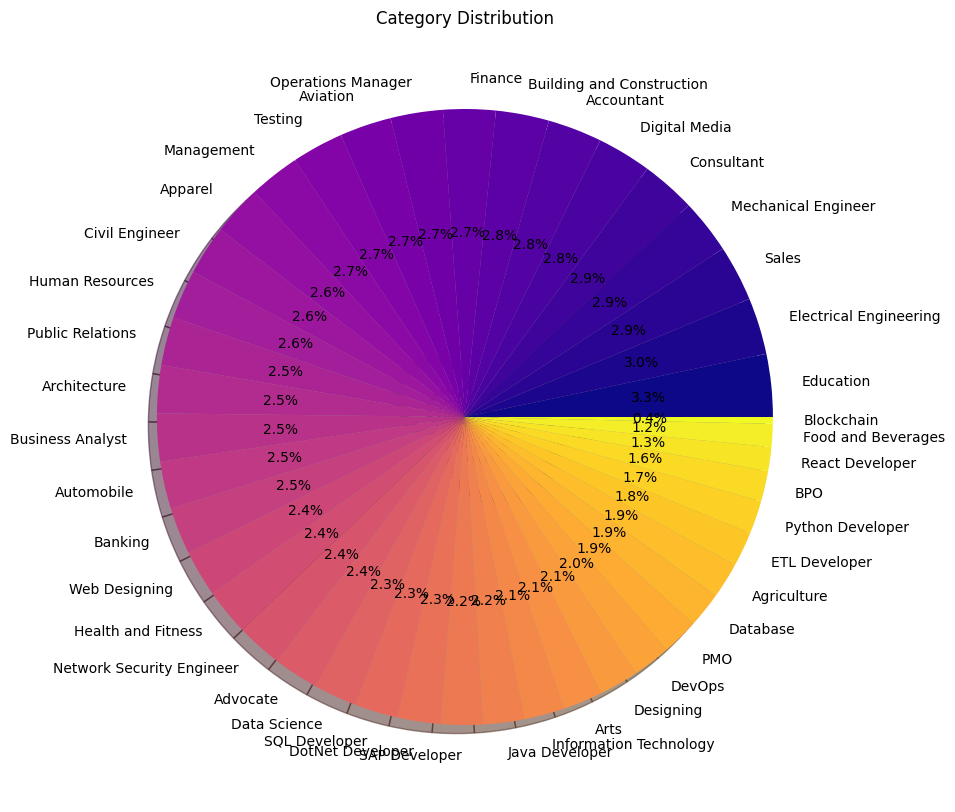

In [7]:
# Category distribution plot
plt.figure(figsize=(15,10))
counts = df['Category'].value_counts()
labels = counts.index
plt.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True, colors=plt.cm.plasma(np.linspace(0,1,len(labels))))
plt.title("Category Distribution")
plt.show()

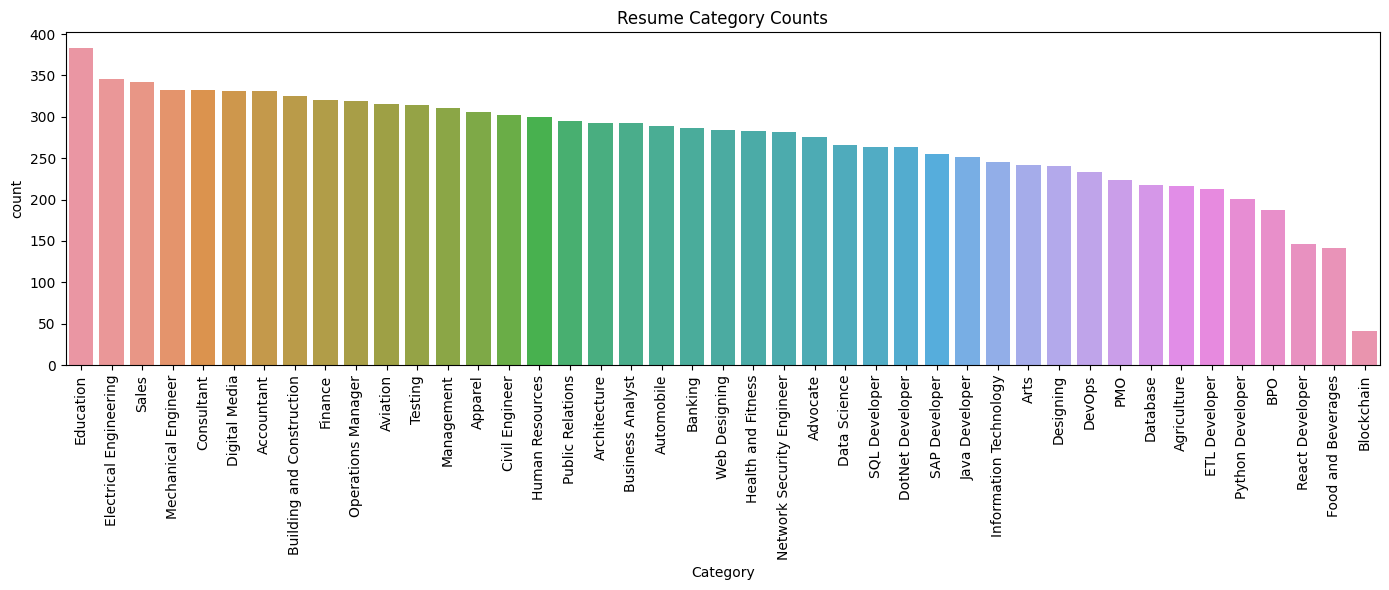

In [8]:
# Countplot for categories
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Resume Category Counts")
plt.tight_layout()
plt.show()

# Balance Dataset by Oversampling and Undersampling

In [9]:
max_count = df['Category'].value_counts().max()
balanced_data = []

for category in df['Category'].unique():
    category_data = df[df['Category'] == category]
    if len(category_data) < max_count:
        # Oversample minority class
        balanced_category = resample(category_data, replace=True, n_samples=max_count, random_state=42)
    else:
        # Undersample majority class
        balanced_category = resample(category_data, replace=False, n_samples=max_count, random_state=42)
    balanced_data.append(balanced_category)

balanced_df = pd.concat(balanced_data).reset_index(drop=True)
print(f"Balanced dataset contains {balanced_df.shape[0]} rows.")

Balanced dataset contains 16469 rows.


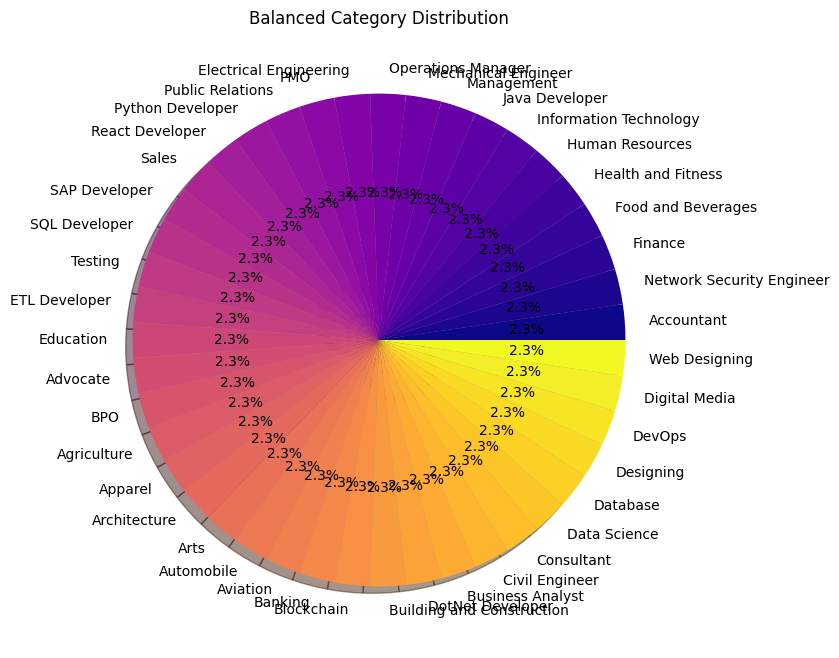

In [10]:
# Plot balanced category distribution
plt.figure(figsize=(15, 8))
counts_balanced = balanced_df['Category'].value_counts()
labels_balanced = counts_balanced.index
plt.pie(counts_balanced, labels=labels_balanced, autopct='%1.1f%%', shadow=True, colors=plt.cm.plasma(np.linspace(0,1,len(labels_balanced))))
plt.title("Balanced Category Distribution")
plt.show()

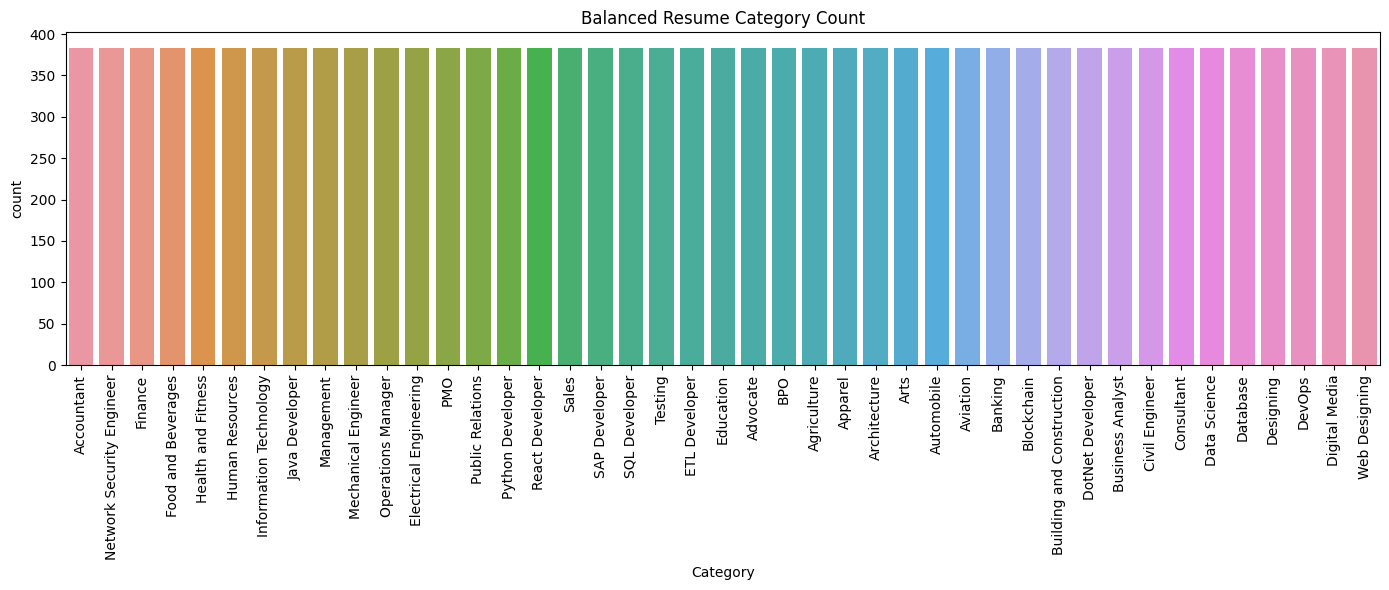

In [11]:
# Countplot for balanced data
plt.figure(figsize=(14, 6))
sns.countplot(data=balanced_df, x='Category', order=balanced_df['Category'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Balanced Resume Category Count")
plt.tight_layout()
plt.show()

# Split features and labels

In [12]:
X = balanced_df['Text']
y = balanced_df['Category']

# Train-test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Random Forest Classifier

In [16]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

# Predict and evaluate

In [17]:
y_pred = rf_classifier.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9256

Classification Report:
                            precision    recall  f1-score   support

               Accountant       0.92      0.97      0.94        88
                 Advocate       0.92      0.97      0.95        72
              Agriculture       0.99      1.00      0.99        69
                  Apparel       0.90      0.94      0.92        67
             Architecture       0.95      0.86      0.90        66
                     Arts       0.90      0.96      0.93        77
               Automobile       0.97      0.89      0.93        85
                 Aviation       0.94      0.99      0.96        74
                      BPO       0.96      0.98      0.97        97
                  Banking       0.92      0.93      0.93        75
               Blockchain       1.00      1.00      1.00        75
Building and Construction       0.92      0.90      0.91        72
         Business Analyst       0.89      0.93      0.91        81
           Civil En

# Confusion matrix heatmap


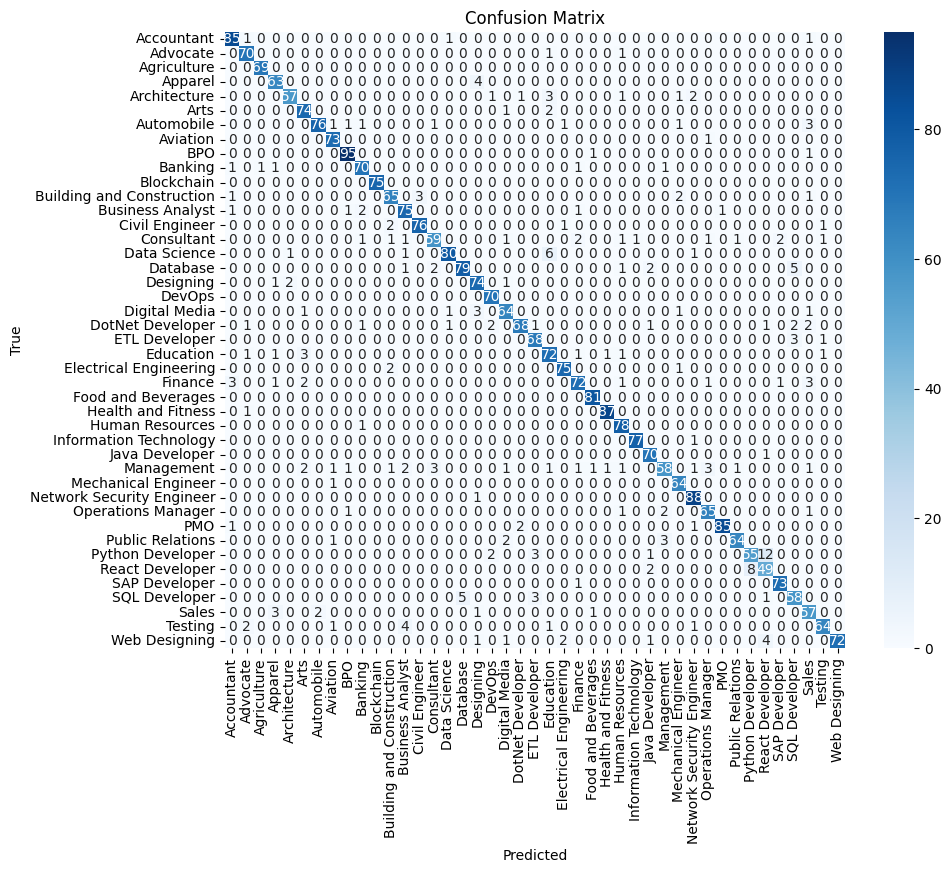

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Predict Category from a New Resume Text

In [19]:
def predict_category(resume_text):
    cleaned_text = clean_text(resume_text)
    vectorized_text = tfidf_vectorizer.transform([cleaned_text])
    prediction = rf_classifier.predict(vectorized_text)[0]
    return prediction

# Example resume
resume_sample = """
Name: Hassan Ali
Email: hassan.dev@gmail.com
Phone: +92-312-7896543
Location: Islamabad, Pakistan

Objective:
Front-end developer passionate about building interactive UIs using React.js and React Native. Seeking to join a fast-paced tech team.

Skills:
- React.js, React Native
- JavaScript (ES6+), TypeScript
- Redux, Context API
- HTML, CSS, TailwindCSS
- REST APIs, Axios
- Git, Webpack

Experience:
Frontend Developer – Xpert Tech (2022–2024)
- Built e-commerce frontend using React + Redux
- Migrated app from class components to functional components with hooks

Education:
BS in Computer Science – COMSATS University, 2021

Projects:
- Portfolio Website using React
- Job Portal App with Firebase integration
"""

predicted_cat = predict_category(resume_sample)
print("Predicted Category:", predicted_cat)


Predicted Category: React Developer
